In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [10]:
# Load data
data = pd.read_csv("../data_cleaned/train_data_cleaned.csv", header=None, names=["tweet", "sentiment"])

# Split data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    data["tweet"].to_numpy()[1:], data["sentiment"].to_numpy()[1:].astype(int), test_size=0.1, random_state=21
)

print("Train data shape:", train_tweets.shape)
print("Test data shape:", test_tweets.shape)

print(train_tweets[0], train_labels[0])

# Adjust labels from -1, 0, 1 to 0, 1, 2
train_labels += 1
test_labels += 1

# Convert tweets to embeddings
#model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("all-mpnet-base-v2")
train_embeddings = model.encode(train_tweets)
test_embeddings = model.encode(test_tweets)
print(len(train_embeddings[0]), len(train_embeddings))

Train data shape: (10006,)
Test data shape: (1112,)
Obama can say what he wants but weve all seen what hes done in the past 4 years Actions speak louder than words HofstraDebate -1
768 10006


In [11]:
unique, counts = np.unique(train_labels, return_counts=True)
percentages = counts / len(train_labels) * 100
weights = []
for label, percentage in zip(unique, percentages):
    print(f"Label {label}: {percentage:.2f}%")
    weights.append(1 / percentage)

weights = np.array(weights)
weights /= weights.sum()
weights

Label 0: 43.34%
Label 1: 32.14%
Label 2: 24.52%


array([0.2429184 , 0.32759238, 0.42948923])

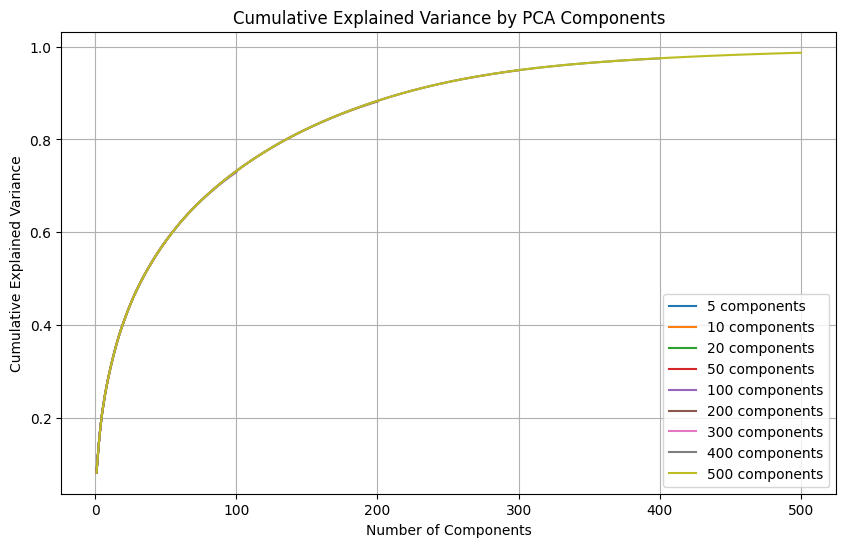

In [12]:
components = [5, 10, 20, 50, 100, 200, 300, 400, 500]
cumulative_variances = []

for n in components:
    pca = PCA(n_components=n)
    pca.fit(train_embeddings)
    cumulative_variances.append(np.cumsum(pca.explained_variance_ratio_))

# Plot cumulative variance
plt.figure(figsize=(10, 6))
for i, n in enumerate(components):
    plt.plot(range(1, n + 1), cumulative_variances[i], label=f'{n} components')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Fit PCA with 250 components
pca_250 = PCA(n_components=200)
train_embeddings_ = pca_250.fit_transform(train_embeddings)
test_embeddings_ = pca_250.transform(test_embeddings)

print("Train embeddings shape after PCA:", train_embeddings_.shape)
print("Test embeddings shape after PCA:", test_embeddings_.shape)

Train embeddings shape after PCA: (10006, 200)
Test embeddings shape after PCA: (1112, 200)


In [23]:
class_weights = {0: 1, 1: 1, 2: 1}
svm_model = SVC(kernel='rbf', class_weight=class_weights)
svm_model.fit(train_embeddings_, train_labels)

SVC(class_weight={0: 1, 1: 1, 2: 1})

In [24]:
svm_predictions = svm_model.predict(test_embeddings_)
report = classification_report(test_labels, svm_predictions, target_names=['class -1', 'class 0', 'class 1'])
print(report)

              precision    recall  f1-score   support

    class -1       0.68      0.82      0.74       478
     class 0       0.63      0.51      0.56       359
     class 1       0.69      0.62      0.65       275

    accuracy                           0.67      1112
   macro avg       0.67      0.65      0.65      1112
weighted avg       0.67      0.67      0.66      1112

